# How to compute and style a transition matrix in Python

## STEP 1: data preparation

In [1]:
import pandas as pd
import numpy as np
import os

## 1.1. LOAD DATA
path_parent_dir = os.path.dirname(os.getcwd())
path_data = f'{path_parent_dir}\data'
path_data_web_scraper = f'{path_data}\web_scraper'
path_data_input = f'{path_data}\input_data'
df_input_data = pd.read_csv(f'{path_data_input}/transition_matrices_input.csv',sep=';')

## 1.2. DATA FILTERING
## 4-YEAR TRANSITION MATRIX BASED ON PROFIT 
df_profit = df_input_data[(df_input_data['measure']=='profits_m')
                          &
                          ((df_input_data['matrix_class_2023']!='na_class')
                          |
                          (df_input_data['matrix_class_2020']!='na_class'))].copy()

df_profit['matrix_class_2020'] = df_profit['matrix_class_2020'].replace('na_class','OoR')
df_profit['matrix_class_2023'] = df_profit['matrix_class_2023'].replace('na_class','NJ')

## SUPPORT LISTS ON THE PROFIT CLASSES 
list_matrix_class_y = [']0% ; 10%]',']10% ; 20%]',']20% ; 30%]',']30% ; 40%]',']40% ; 50%]',
                       ']50% ; 60%]',']60% ; 70%]',']70% ; 80%]',']80% ; 90%]',']90% ; 100%]','<=0', 'NJ','All'] 
list_matrix_class_y_prev = [']0% ; 10%]',']10% ; 20%]',']20% ; 30%]',']30% ; 40%]',']40% ; 50%]',
                            ']50% ; 60%]',']60% ; 70%]',']70% ; 80%]',']80% ; 90%]',']90% ; 100%]','<=0', 'OoR','All']

## STEP 2: compute the transition matrix by using a crosstab

In [2]:
df_crosstab_norm = pd.crosstab(df_profit.matrix_class_2020,
                               df_profit.matrix_class_2023,
                               rownames=['Y2020'],
                               colnames=['Y2023'],
                               margins=True,
                               normalize=True).reindex(list_matrix_class_y_prev)[list_matrix_class_y]

df_crosstab_norm = df_crosstab_norm*100

## STEP 3: style the transition matrix
### 4-Year profit transition matrix

In [3]:
def set_background_color(df):
    """
    To set the background color of the multiple transition matrix segments
    Based on the approach proposed on Stack Overflow by anky (question 57595257, Aug 21 2019)
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """ 
    # 1. LIGHT REDS SEGMENT (UPPER TRIANGULAR EXCEPT THE LARGEST RECTANGLE INSIDE OF IT): SLIGHT NEGATIVE TRANSACTION 
    mask_light_reds = np.triu(np.ones(df_crosstab_norm.shape),1).astype(bool)
    mask_light_reds[:,np.shape(mask_light_reds)[1]-2:]=False
    mask_light_reds[:5,6:-2]=False
    # 2. DARK REDS SEGMENT (LARGEST RECTANGLE OF THE UPPER TRIANGULAR): STEEP NEGATIVE TRANSACTION 
    mask_dark_reds = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_reds[:5,6:-2]=True
    # 3. LIGHT GREENS SEGMENT (LOWER TRIANGULAR EXCEPT THE LARGEST RECTANGLE INSIDE OF IT): SLIGHT POSITIVE TRANSACTION 
    mask_light_greens = np.tril(np.ones(df_crosstab_norm.shape),-1).astype(bool)
    mask_light_greens[np.shape(mask_light_greens)[0]-2:]=False
    mask_light_greens[6:-2,:5]=False
    # 4. DARK GREENS SEGMENT (LARGEST RECTANGLE OF THE LOWER TRIANGULAR): STEEP POSITIVE TRANSACTION 
    mask_dark_greens = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_greens[6:-2,:5]=True
    # 5. YELLOWS SEGMENT (DIAGONAL): UNCHANGING PROFIT CLASSES    
    mask_yellows = np.eye(np.ones(df_crosstab_norm.shape).shape[0], dtype=bool)
    mask_yellows[np.shape(mask_yellows)[0]-2:,np.shape(mask_yellows)[1]-2:]=False
    # 6. BLUES SEGMENT: NEW JOINERS    
    mask_new_joiners = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_new_joiners[np.shape(mask_new_joiners)[0]-2:np.shape(mask_new_joiners)[0]-1,
                      :np.shape(mask_yellows)[1]-1]=True
    mask_new_joiners[:np.shape(mask_new_joiners)[0]-2,
                      np.shape(mask_yellows)[1]-2:np.shape(mask_yellows)[1]-1]=True
    # COLORS
    light_red = 'background-color: #ff7b7b'
    dark_red = 'background-color: #ff0000'
    light_green = 'background-color: #21D375'
    dark_green = 'background-color: #019875'
    light_orange = 'background-color: #ffc100'
    blue = 'background-color: #3876BF'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_light_reds,mask_dark_reds,mask_light_greens,mask_dark_greens,
                                   mask_yellows,mask_new_joiners],
                                  [light_red,dark_red,light_green,dark_green,light_orange,blue],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

## STYLE THE TRANSITION MATRIX 
four_year_profit_tm = (df_crosstab_norm.style
                                       .set_table_styles([{"selector":"th.row_heading","props":[("background-color","white")]},
                                                            {"selector":"th","props":[('text-align', 'center')]},
                                                            {'selector': 'th','props': [('border', '1px white solid !important')]}])
                                       .set_properties(**{'color': 'white',
                                                          'border': '1px white solid !important',
                                                          'text-align': 'center',
                                                          'width': '45px',
                                                          'max-width': '45px'})
                                       .apply(set_background_color, axis=None)
                                       .format('{:.2f}')
                        )

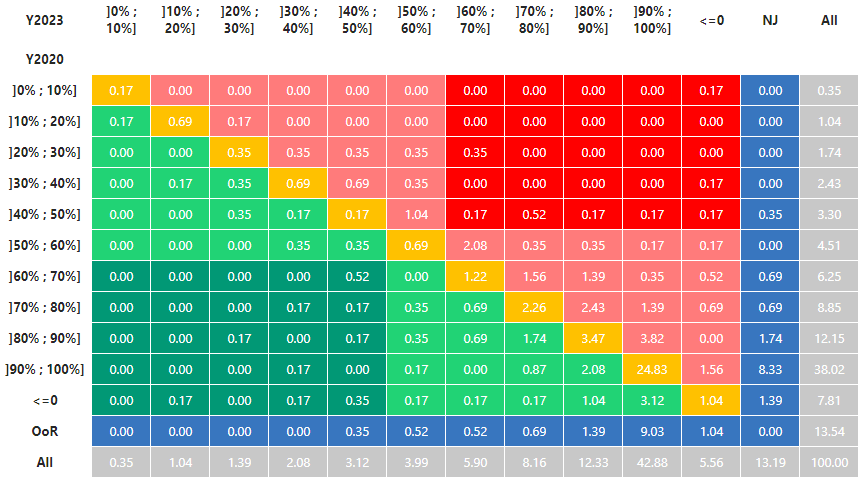

### Complementar segment analysis
#### 1. Global positive transition likelihood

In [4]:
def style_tm_segment(df,set_segment_bgd_color):
    return (df.style
              .set_table_styles([{"selector":"th.row_heading","props":[("background-color","white")]}
                                 ,
                                 {"selector":"th","props":[('text-align', 'center')]}
                                 ,
                                 {'selector': 'th','props': [('border', '1px white solid !important')]}])
              .set_properties(**{'color': 'white',
                                 'border': '1px white solid !important',
                                 'text-align': 'center',
                                 'width': '45px',
                                 'max-width': '45px'})
              .apply(set_segment_bgd_color, axis=None)
              .format('{:.2f}')
            )

def set_l_triang_bg_color(df):
    """
    To set the background color of the lower triangular of the transition matrix
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_lower_triang = np.tril(np.ones(df_crosstab_norm.shape),-1).astype(bool)
    mask_lower_triang[np.shape(mask_lower_triang)[0]-2:]=False

    light_green = 'background-color: #21D375'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_lower_triang],[light_green],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

style_tm_segment(df_crosstab_norm,set_l_triang_bg_color)

Y2023,]0% ; 10%],]10% ; 20%],]20% ; 30%],]30% ; 40%],]40% ; 50%],]50% ; 60%],]60% ; 70%],]70% ; 80%],]80% ; 90%],]90% ; 100%],<=0,NJ,All
Y2020,,,,,,,,,,,,,
]0% ; 10%],0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.35
]10% ; 20%],0.17,0.69,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.04
]20% ; 30%],0.00,0.00,0.35,0.35,0.35,0.35,0.35,0.00,0.00,0.00,0.00,0.00,1.74
]30% ; 40%],0.00,0.17,0.35,0.69,0.69,0.35,0.00,0.00,0.00,0.00,0.17,0.00,2.43
]40% ; 50%],0.00,0.00,0.35,0.17,0.17,1.04,0.17,0.52,0.17,0.17,0.17,0.35,3.30
]50% ; 60%],0.00,0.00,0.00,0.35,0.35,0.69,2.08,0.35,0.35,0.17,0.17,0.00,4.51
]60% ; 70%],0.00,0.00,0.00,0.00,0.52,0.00,1.22,1.56,1.39,0.35,0.52,0.69,6.25
]70% ; 80%],0.00,0.00,0.00,0.17,0.17,0.35,0.69,2.26,2.43,1.39,0.69,0.69,8.85
]80% ; 90%],0.00,0.00,0.17,0.00,0.17,0.35,0.69,1.74,3.47,3.82,0.00,1.74,12.15


In [5]:
pos_trans_likelihood = round(np.tril(df_crosstab_norm,-1).sum() - df_crosstab_norm.iloc[-2:,:-1].values.sum(),1)
print(f'The likelihood of a company showing a positive transition between the profit classes is {pos_trans_likelihood}%')

The likelihood of a company showing a positive transition between the profit classes is 15.6%


#### 2. Steep positive transition likelihood: moving from the lower to the upper classes  

In [6]:
def set_dark_green_seg_bg_color(df):
    """
    To set the background color of the steep positive transition segmemt
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_dark_greens = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_greens[6:-2,:5]=True

    dark_green = 'background-color: #019875'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_dark_greens],[dark_green],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

style_tm_segment(df_crosstab_norm,set_dark_green_seg_bg_color)

Y2023,]0% ; 10%],]10% ; 20%],]20% ; 30%],]30% ; 40%],]40% ; 50%],]50% ; 60%],]60% ; 70%],]70% ; 80%],]80% ; 90%],]90% ; 100%],<=0,NJ,All
Y2020,,,,,,,,,,,,,
]0% ; 10%],0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.35
]10% ; 20%],0.17,0.69,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.04
]20% ; 30%],0.00,0.00,0.35,0.35,0.35,0.35,0.35,0.00,0.00,0.00,0.00,0.00,1.74
]30% ; 40%],0.00,0.17,0.35,0.69,0.69,0.35,0.00,0.00,0.00,0.00,0.17,0.00,2.43
]40% ; 50%],0.00,0.00,0.35,0.17,0.17,1.04,0.17,0.52,0.17,0.17,0.17,0.35,3.30
]50% ; 60%],0.00,0.00,0.00,0.35,0.35,0.69,2.08,0.35,0.35,0.17,0.17,0.00,4.51
]60% ; 70%],0.00,0.00,0.00,0.00,0.52,0.00,1.22,1.56,1.39,0.35,0.52,0.69,6.25
]70% ; 80%],0.00,0.00,0.00,0.17,0.17,0.35,0.69,2.26,2.43,1.39,0.69,0.69,8.85
]80% ; 90%],0.00,0.00,0.17,0.00,0.17,0.35,0.69,1.74,3.47,3.82,0.00,1.74,12.15


In [7]:
steep_pos_trans_likelihood = round(df_crosstab_norm.iloc[6:-2,:5].values.sum(),1)
print(f'The likelihood of a company showing a steep positive transition between the \
profit classes is {steep_pos_trans_likelihood}%')

The likelihood of a company showing a steep positive transition between the profit classes is 2.1%


#### 3. Global negative transition likelihood

In [8]:
def set_u_triang_bg_color(df):
    """
    To set the background color of the upper triangular of the transition matrix
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_upper_triang = np.triu(np.ones(df_crosstab_norm.shape),1).astype(bool)
    mask_upper_triang[:,np.shape(mask_upper_triang)[1]-2:]=False

    light_red = 'background-color: #ff7b7b'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_upper_triang],[light_red],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

style_tm_segment(df_crosstab_norm,set_u_triang_bg_color)

Y2023,]0% ; 10%],]10% ; 20%],]20% ; 30%],]30% ; 40%],]40% ; 50%],]50% ; 60%],]60% ; 70%],]70% ; 80%],]80% ; 90%],]90% ; 100%],<=0,NJ,All
Y2020,,,,,,,,,,,,,
]0% ; 10%],0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.35
]10% ; 20%],0.17,0.69,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.04
]20% ; 30%],0.00,0.00,0.35,0.35,0.35,0.35,0.35,0.00,0.00,0.00,0.00,0.00,1.74
]30% ; 40%],0.00,0.17,0.35,0.69,0.69,0.35,0.00,0.00,0.00,0.00,0.17,0.00,2.43
]40% ; 50%],0.00,0.00,0.35,0.17,0.17,1.04,0.17,0.52,0.17,0.17,0.17,0.35,3.30
]50% ; 60%],0.00,0.00,0.00,0.35,0.35,0.69,2.08,0.35,0.35,0.17,0.17,0.00,4.51
]60% ; 70%],0.00,0.00,0.00,0.00,0.52,0.00,1.22,1.56,1.39,0.35,0.52,0.69,6.25
]70% ; 80%],0.00,0.00,0.00,0.17,0.17,0.35,0.69,2.26,2.43,1.39,0.69,0.69,8.85
]80% ; 90%],0.00,0.00,0.17,0.00,0.17,0.35,0.69,1.74,3.47,3.82,0.00,1.74,12.15


In [9]:
neg_trans_likelihood = round(np.triu(df_crosstab_norm,1).sum() - df_crosstab_norm.iloc[:-1,-2:].values.sum(),1)
print(f'The likelihood of a company showing a negative transition between the profit classes is {neg_trans_likelihood}%')

The likelihood of a company showing a negative transition between the profit classes is 22.0%


#### 4. Steep negative transition likelihood: moving from the upper to the lower classes

In [10]:
def set_dark_red_seg_bg_color(df):
    """
    To set the background color of the steep negative transition segmemt
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_dark_reds = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_reds[:5,6:-2]=True

    dark_red = 'background-color: #ff0000'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_dark_reds],[dark_red],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

style_tm_segment(df_crosstab_norm,set_dark_red_seg_bg_color)

Y2023,]0% ; 10%],]10% ; 20%],]20% ; 30%],]30% ; 40%],]40% ; 50%],]50% ; 60%],]60% ; 70%],]70% ; 80%],]80% ; 90%],]90% ; 100%],<=0,NJ,All
Y2020,,,,,,,,,,,,,
]0% ; 10%],0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.35
]10% ; 20%],0.17,0.69,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.04
]20% ; 30%],0.00,0.00,0.35,0.35,0.35,0.35,0.35,0.00,0.00,0.00,0.00,0.00,1.74
]30% ; 40%],0.00,0.17,0.35,0.69,0.69,0.35,0.00,0.00,0.00,0.00,0.17,0.00,2.43
]40% ; 50%],0.00,0.00,0.35,0.17,0.17,1.04,0.17,0.52,0.17,0.17,0.17,0.35,3.30
]50% ; 60%],0.00,0.00,0.00,0.35,0.35,0.69,2.08,0.35,0.35,0.17,0.17,0.00,4.51
]60% ; 70%],0.00,0.00,0.00,0.00,0.52,0.00,1.22,1.56,1.39,0.35,0.52,0.69,6.25
]70% ; 80%],0.00,0.00,0.00,0.17,0.17,0.35,0.69,2.26,2.43,1.39,0.69,0.69,8.85
]80% ; 90%],0.00,0.00,0.17,0.00,0.17,0.35,0.69,1.74,3.47,3.82,0.00,1.74,12.15


In [11]:
steep_neg_trans_likelihood = round(df_crosstab_norm.iloc[:5,6:-2].values.sum(),1)
print(f'The likelihood of a company showing a steep negative transition between the \
profit classes is {steep_neg_trans_likelihood}%')

The likelihood of a company showing a steep negative transition between the profit classes is 1.9%


#### 5. Unchanging profit classes

In [12]:
def set_unchang_class_bg_color(df):
    """
    To set the background color of the unchanging classes of the transition matrix
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_diagonal = np.eye(np.ones(df_crosstab_norm.shape).shape[0], dtype=bool)
    mask_diagonal[np.shape(mask_diagonal)[0]-2:,np.shape(mask_diagonal)[1]-2:]=False

    light_orange = 'background-color: #ffc100'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_diagonal],[light_orange],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

style_tm_segment(df_crosstab_norm,set_unchang_class_bg_color)

Y2023,]0% ; 10%],]10% ; 20%],]20% ; 30%],]30% ; 40%],]40% ; 50%],]50% ; 60%],]60% ; 70%],]70% ; 80%],]80% ; 90%],]90% ; 100%],<=0,NJ,All
Y2020,,,,,,,,,,,,,
]0% ; 10%],0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.35
]10% ; 20%],0.17,0.69,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.04
]20% ; 30%],0.00,0.00,0.35,0.35,0.35,0.35,0.35,0.00,0.00,0.00,0.00,0.00,1.74
]30% ; 40%],0.00,0.17,0.35,0.69,0.69,0.35,0.00,0.00,0.00,0.00,0.17,0.00,2.43
]40% ; 50%],0.00,0.00,0.35,0.17,0.17,1.04,0.17,0.52,0.17,0.17,0.17,0.35,3.30
]50% ; 60%],0.00,0.00,0.00,0.35,0.35,0.69,2.08,0.35,0.35,0.17,0.17,0.00,4.51
]60% ; 70%],0.00,0.00,0.00,0.00,0.52,0.00,1.22,1.56,1.39,0.35,0.52,0.69,6.25
]70% ; 80%],0.00,0.00,0.00,0.17,0.17,0.35,0.69,2.26,2.43,1.39,0.69,0.69,8.85
]80% ; 90%],0.00,0.00,0.17,0.00,0.17,0.35,0.69,1.74,3.47,3.82,0.00,1.74,12.15


In [13]:
no_change_likelihood = round(np.trace(df_crosstab_norm.to_numpy()) - (df_crosstab_norm.iloc[-2,-2] + df_crosstab_norm.iloc[-1,-1]),1)
print(f'The likelihood of a company keeping stable across the profit classes is {no_change_likelihood}%')

The likelihood of a company keeping stable across the profit classes is 35.6%
